# Build CNN Regression Model

**Using the airline passengers dataset, build a basic Convolutional Neural Network to see if this type of neural network performs better on a univariate time series with strong trend and seasonality components. Since CNNs are known as pattern-finders, compare to the performance of an ANN.**

**CNNs were originally designed for image resolution and identification, where a filter or *kernel* is applied to the input image to produce, for example, a blurred version. The output is a modified version of the input, and the kernel acts like a feature transformer. The impact of the kernel depends on its size.**

**With regards to univariate time series, in TensorFlow the CNN is built with one-dimensional convolutions and pooling layers, where you specify number of feature maps or `filters` at each layer.**

**Since this is a regression task, we will be predicting using:**

* **one-step forecast** 
* **incremental multi-step forecast**
* **multi-output multi-step forecast**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

%matplotlib inline

In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
df = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df['LogPassengers'] = np.log(df['Passengers'])

In [5]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [6]:
# Note null value due to differencing

df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


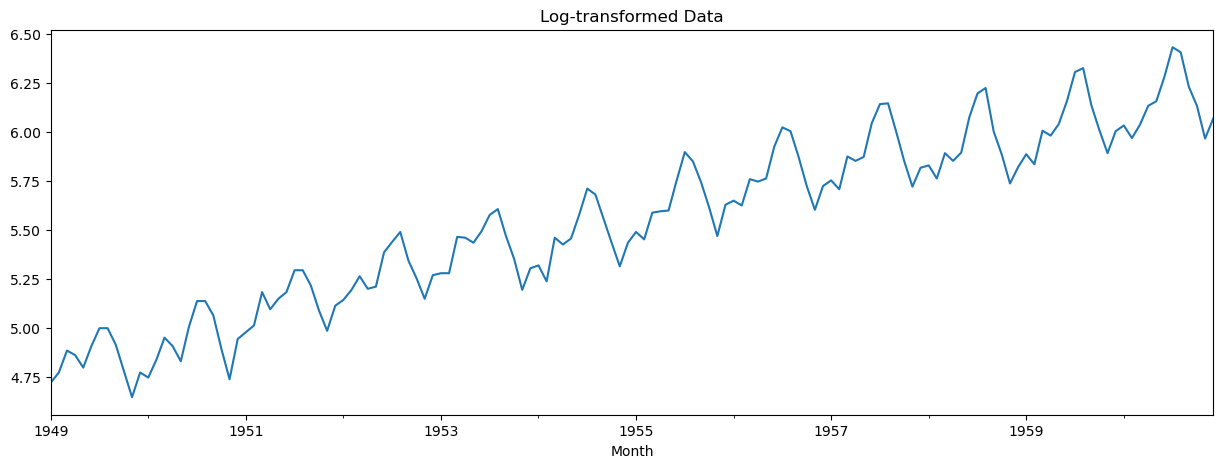

In [7]:
df['LogPassengers'].plot(figsize=(15, 5))
plt.title("Log-transformed Data");

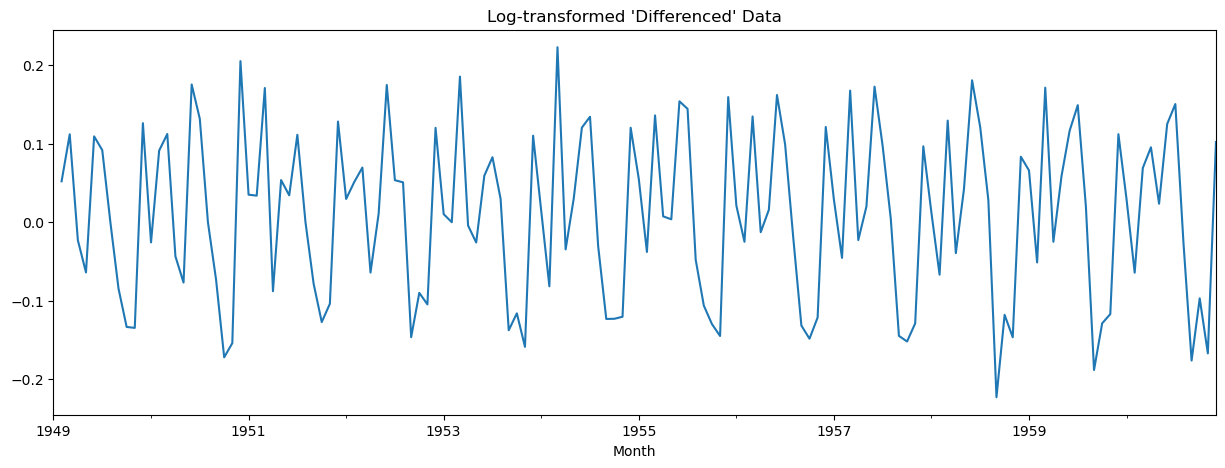

In [8]:
df['DiffLogPassengers'].plot(figsize=(15, 5))
plt.title("Log-transformed 'Differenced' Data");

In [9]:
# Create training and test sets

N_test = 12

train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [10]:
# Boolean series to index df rows

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [11]:
# Make supervised dataset for one-step and multi-step forecasts

series = df['DiffLogPassengers'].dropna().to_numpy()

# Use ten past lags to predict next value
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T] 
    Y.append(y)

# Convert to NumPy - input must N x T x D
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [12]:
# Split X and Y into X_train, y_train, X_test, y_test

X_train, y_train = X[:-N_test], Y[:-N_test]

X_test, y_test = X[-N_test:], Y[-N_test:]

## Build CNN Model

**The input for univariate time series is *N* x *T* x *D* (133 samples x 10 past timesteps x 1 dimension), and since it is one-dimensional data, you use `Conv1D` layers with `MaxPooling1D` (default pool size is 2) in TensorFlow.**

In [13]:
i = Input(shape=(T, 1))

x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)

x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(1)(x)

model = Model(i, x)

In [14]:
# Notice that T dimension halves each layer as the number of feature maps increase

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 8, 16)             64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33    

In [15]:
model.compile(loss='mse', optimizer='adam')

In [16]:
r = model.fit(X_train, 
              y_train, 
              epochs=100, 
              validation_data=(X_test, y_test))

Epoch 1/100
4/4 [==============================] - 1s 49ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0107 - val_loss: 0.0116
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0103 - val_loss: 0.0111
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0102
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0085 - val_loss: 0.0096
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0092
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0073 - val_loss: 0.0087
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0066 - val_loss: 0.0083
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0079
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0058 - val_loss: 0.0074
Epoch 11/100
4/4 [=

Epoch 83/100
4/4 [==============================] - 0s 11ms/step - loss: 7.6384e-04 - val_loss: 0.0046
Epoch 84/100
4/4 [==============================] - 0s 11ms/step - loss: 7.8721e-04 - val_loss: 0.0046
Epoch 85/100
4/4 [==============================] - 0s 11ms/step - loss: 7.5944e-04 - val_loss: 0.0046
Epoch 86/100
4/4 [==============================] - 0s 10ms/step - loss: 7.4724e-04 - val_loss: 0.0045
Epoch 87/100
4/4 [==============================] - 0s 11ms/step - loss: 7.4070e-04 - val_loss: 0.0046
Epoch 88/100
4/4 [==============================] - 0s 10ms/step - loss: 7.3888e-04 - val_loss: 0.0047
Epoch 89/100
4/4 [==============================] - 0s 11ms/step - loss: 7.4456e-04 - val_loss: 0.0046
Epoch 90/100
4/4 [==============================] - 0s 7ms/step - loss: 7.1507e-04 - val_loss: 0.0048
Epoch 91/100
4/4 [==============================] - 0s 6ms/step - loss: 7.5673e-04 - val_loss: 0.0046
Epoch 92/100
4/4 [==============================] - 0s 6ms/step - loss: 7.2

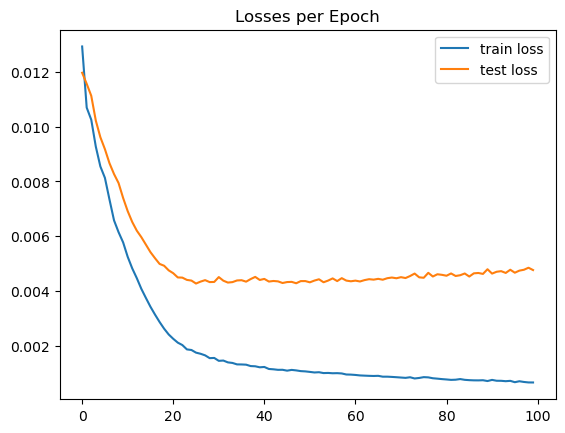

In [17]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

**The training loss decreases nicely, and faster than the test losses, which is expected. At one-step method, the model seems to be learning the data quite well.**

In [18]:
# Remember that first T + 1 values are not predictable

train_idx[:T+1] = False 

In [19]:
P_train = model.predict(X_train).flatten()

P_test = model.predict(X_test).flatten()

1/1 [==============================] - 0s 17ms/step


In [20]:
# Store diffed predictions

df.loc[train_idx, 'Diff Train Prediction'] = P_train
df.loc[test_idx, 'Diff Test Prediction'] = P_test

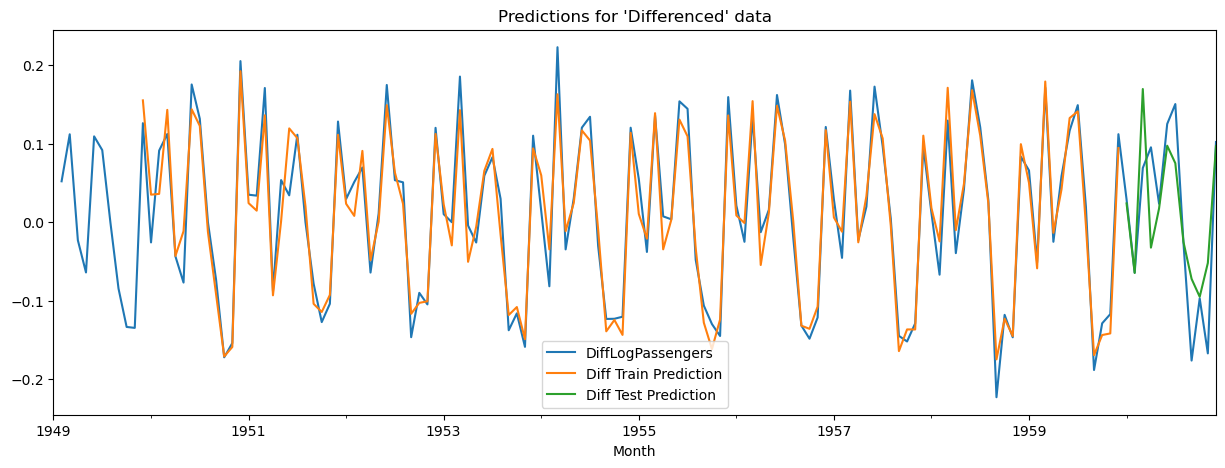

In [21]:
cols = ['DiffLogPassengers', 'Diff Train Prediction', 'Diff Test Prediction']

df[cols].plot(figsize=(15, 5))
plt.title("Predictions for 'Differenced' data");

In [22]:
# Compute un-differenced predictions

df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)

prev = df['ShiftLogPassengers']

In [23]:
# Obtain last-known train value (for multi-step predictions)

last_train = train.iloc[-1]['LogPassengers']

In [24]:
# One-step forecast

df.loc[train_idx, 'onestep_train'] = prev[train_idx] + P_train

df.loc[test_idx, 'onestep_test'] = prev[test_idx] + P_test

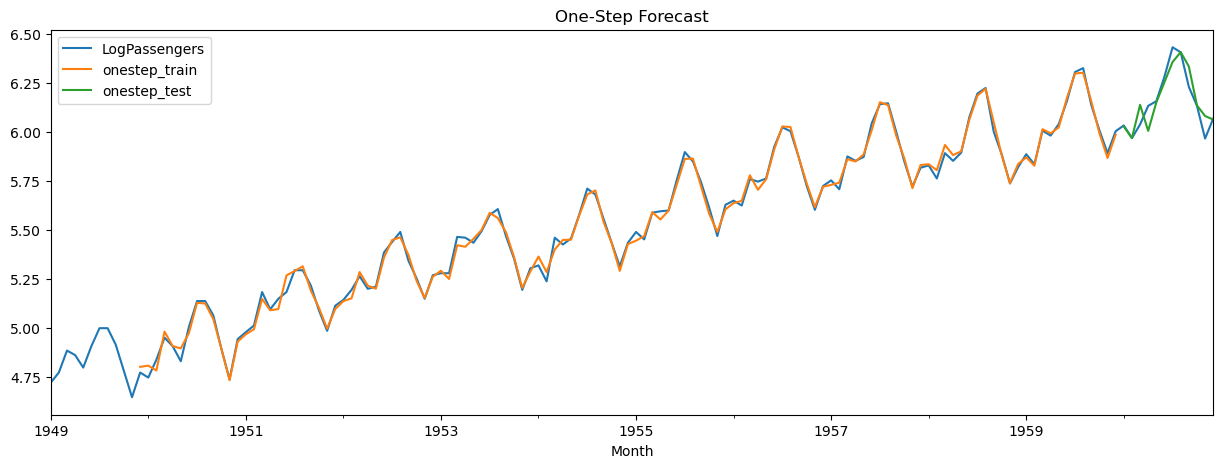

In [25]:
df[['LogPassengers', 'onestep_train', 'onestep_test']].plot(figsize=(15, 5))
plt.title("One-Step Forecast");

**The model has learnt the training data well, but misses the quick dip in the test data, before passengers quickly increase to a peak. Saying that, the predictions follow the data quite closely. Remember that this is just the one-step forecast.**

In [26]:
# Multi-step forecasts

multistep_predictions = []

# First test input
last_x = X_test[0]

while len(multistep_predictions) < N_test:
    p = model.predict(last_x.reshape(1, -1, 1))[0]
    
    # Update the predictions list
    multistep_predictions.append(p)
    
    # Make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 17ms/step


In [27]:
# Save multi-step forecast to df

df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

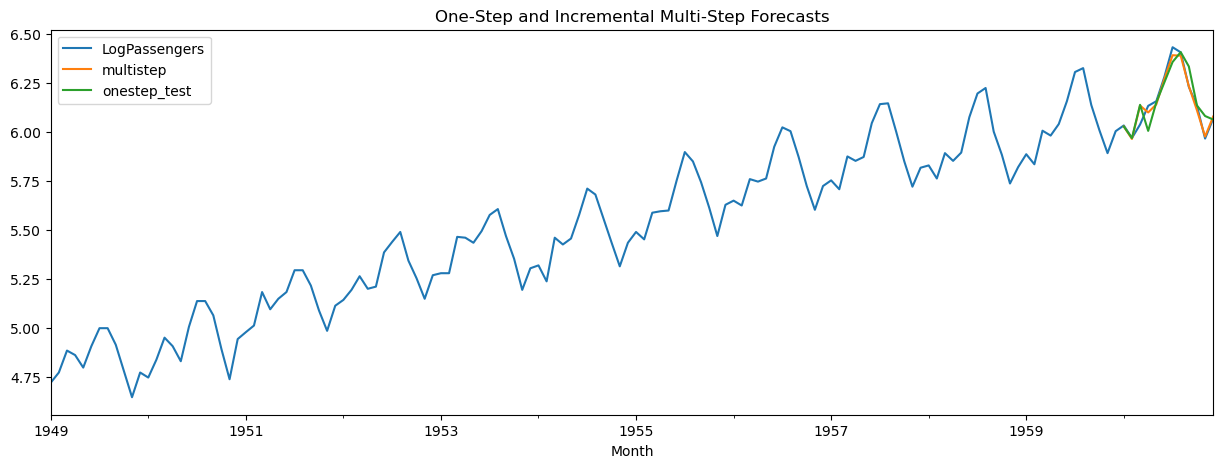

In [28]:
df[['LogPassengers', 'multistep', 'onestep_test']].plot(figsize=(15, 5))
plt.title("One-Step and Incremental Multi-Step Forecasts");

**The multi-step forecast looks a bit better than the one-step, by learning the pattern of the data more fully, which makes sense due to the cyclical nature of the data and using past lags to predict.**

**The next step is to generate the multi-output predictions.**

In [29]:
# Make multi-output supervised dataset

Tx = T
Ty = N_test
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

# Convert to NumPy arrays
X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [30]:
# Split X and Y into Xtrain, Ytrain, Xtest, Ytest

Xtrain, Ytrain = X[:-1], Y[:-1]

Xtest, Ytest = X[-1:], Y[-1:]

In [31]:
# Rebuild CNN

i = Input(shape=(Tx, 1))

x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)

x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(Ty)(x)

model = Model(i, x)

In [32]:
model.compile(loss='mse', optimizer='adam')

In [33]:
r = model.fit(Xtrain, 
              Ytrain, 
              epochs=200, 
              validation_data=(Xtest, Ytest))

Epoch 1/200
4/4 [==============================] - 1s 42ms/step - loss: 0.0117 - val_loss: 0.0113
Epoch 2/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 3/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.0101
Epoch 4/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 5/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0103 - val_loss: 0.0090
Epoch 6/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0100 - val_loss: 0.0085
Epoch 7/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0098 - val_loss: 0.0082
Epoch 8/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 9/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0074
Epoch 10/200
4/4 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0072
Epoch 11/200
4/4 [==

Epoch 84/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 85/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 86/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 87/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 88/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 89/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 90/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 91/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 92/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 93/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 94/20

4/4 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 167/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 168/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 169/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 170/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 171/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 172/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 173/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 174/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 175/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 176/200
4/

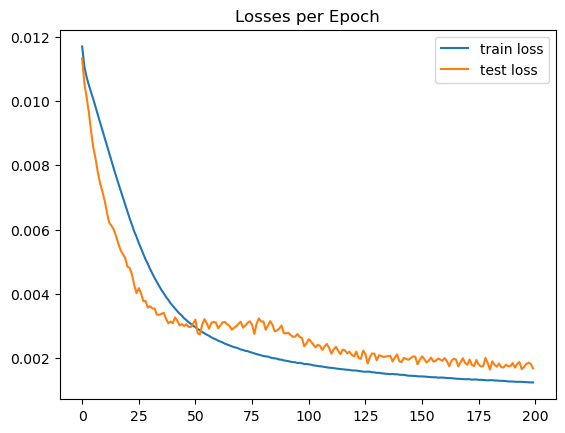

In [34]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

**Even though the test losses are stochastic, they show steady decrease and convergence indicating better model learning.**

In [35]:
Ptrain = model.predict(Xtrain)

Ptest = model.predict(Xtest)

1/1 [==============================] - 0s 17ms/step


In [36]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [37]:
# Grab closest value

Ptrain = Ptrain[:, 0]

Ptest = Ptest[0]

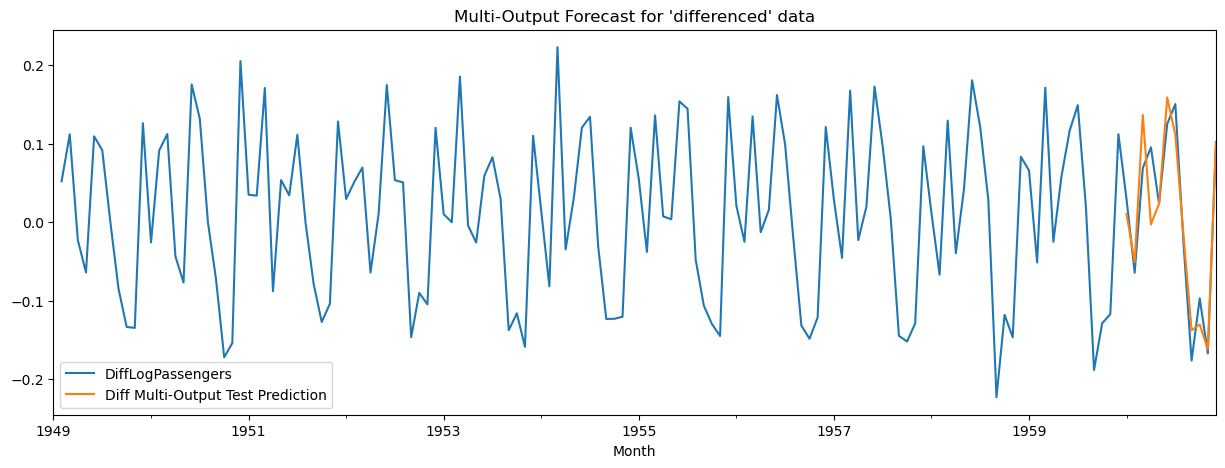

In [38]:
# Store differenced multi-output forecast to df
df.loc[test_idx, 'Diff Multi-Output Test Prediction'] = Ptest

# Plot differenced multi-output forecast
cols = ['DiffLogPassengers', 'Diff Multi-Output Test Prediction']

df[cols].plot(figsize=(15, 5))
plt.title("Multi-Output Forecast for 'differenced' data");

In [39]:
# Save multi-output forecast to df as undifferenced

df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

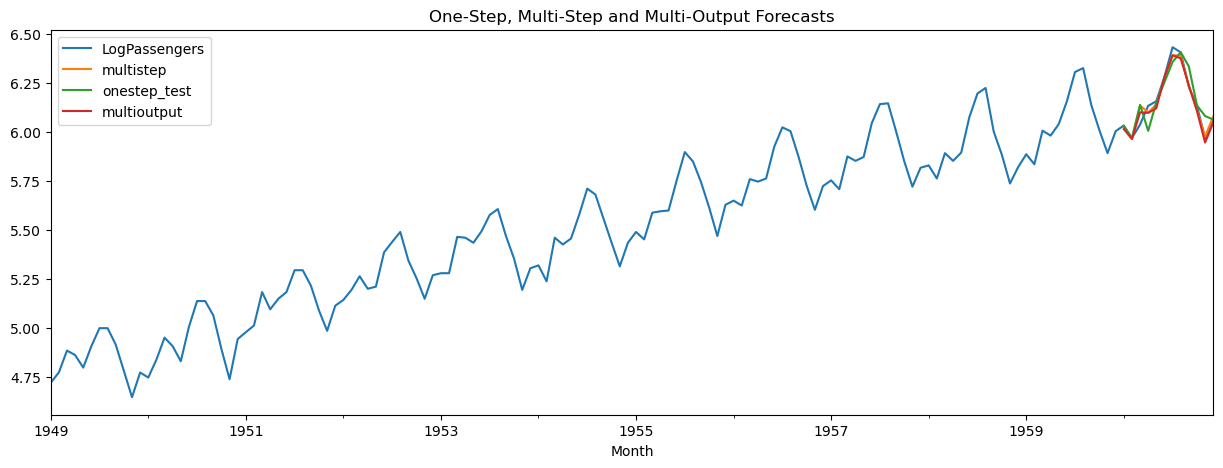

In [40]:
# Plot all forecasts
cols = ['LogPassengers', 'multistep', 'onestep_test', 'multioutput']

df[cols].plot(figsize=(15, 5))
plt.title("One-Step, Multi-Step and Multi-Output Forecasts");

**The multi-output performs as well as the multi-step forecast the data, maybe even better. Use performance metric to measure model accuracy.**

In [41]:
# Compute MAPE
test_log_pass = df.iloc[-N_test:]['LogPassengers']

mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.0036750747904609666
multi-output MAPE: 0.004155190097919465


**As expected, the multi-step MAPE scores better than multi-output, showing the incremental multi-step forecasting method to yield the best results.**

**EXERCISE:**

* **Do you think differencing is unnecessary? Try without.**
* **Do you think logging is unnecessary?** 
* **Do you think including more past lags would be useful?**
* **Have you considered walk-forward validation to optimize hyperparameters?**